# IART Assignment 2 - Airlines Delay

## Group

* Daniela Tomás, up202004946
* Diogo Nunes, up202007895
* João Veloso, up202005801

## Data analysis

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np 

data = pd.read_csv('airlines_delay.csv')

data.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0


In [29]:
data.describe()

,Flight,Time,Length,DayOfWeek,Class
count,539382.000000,539382.000000,539382.000000,539382.000000,539382.000000
mean,2427.927988,802.728161,132.202104,3.929666,0.445443
std,2067.431700,278.045546,70.117045,1.914666,0.497015
min,1.000000,10.000000,0.000000,1.000000,0.000000
25%,712.000000,565.000000,81.000000,2.000000,0.000000
50%,1809.000000,795.000000,115.000000,4.000000,0.000000
75%,3745.000000,1035.000000,162.000000,5.000000,1.000000
max,7814.000000,1439.000000,655.000000,7.000000,1.000000


In [24]:
print("There are " + str(data.shape[0]) + " rows and " + str(data.shape[1]) + " cols in the dataset")

There are 539382 rows and 8 cols in the dataset


<Axes: xlabel='Class', ylabel='count'>

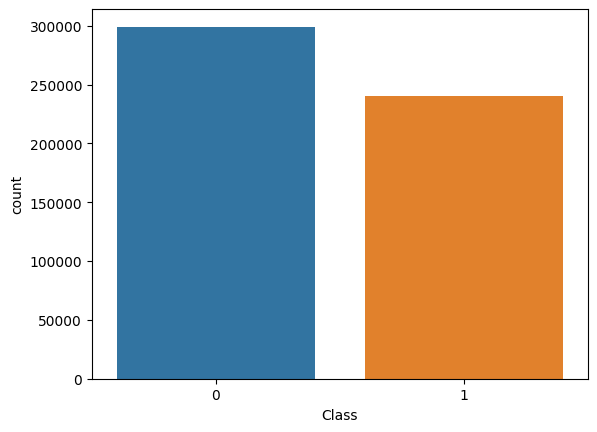

In [37]:
%matplotlib inline

sb.countplot(x = 'Class', data = data)
# 0 = flight not delayed
# 1 = flight delayed

### Attributes
 
Attribute | Type | Properties | Discrete vs Continuous |
| - | - | - | - |
| Flight | Nominal | Distinctness | Discrete |
| Time | Interval | Distinctness, order, and meaningful differences | Continuous |
| Length | Ratio | Distinctness, order, meaningful differences, and ratios are meaningful | Continuous |
| Airline | Nominal | Distinctness | Discrete |
| AirportFrom | Nominal | Distinctness | Discrete |
| AirportTo | Nominal | Distinctness | Discrete |
| DayOfWeek | Ordinal | Distinctness and order | Discrete | 
| Class | Nominal | Distinctness | Discrete |

## Data pre-processing

### NA values

In [25]:
print(data.isna().sum())
print()
print("There are " + str((data.isna().sum().sum())) + " NA values")

Flight         0
Time           0
Length         0
Airline        0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Class          0
dtype: int64

There are 0 NA values


### Duplicate values

In [26]:
length = len(data)
##data.drop_duplicates(inplace=True)

print("Original dataset length: " + str(length))
print("Number of duplicates: " + str(length - len(data)))

Original dataset length: 539382
Number of duplicates: 216618


### Outliers

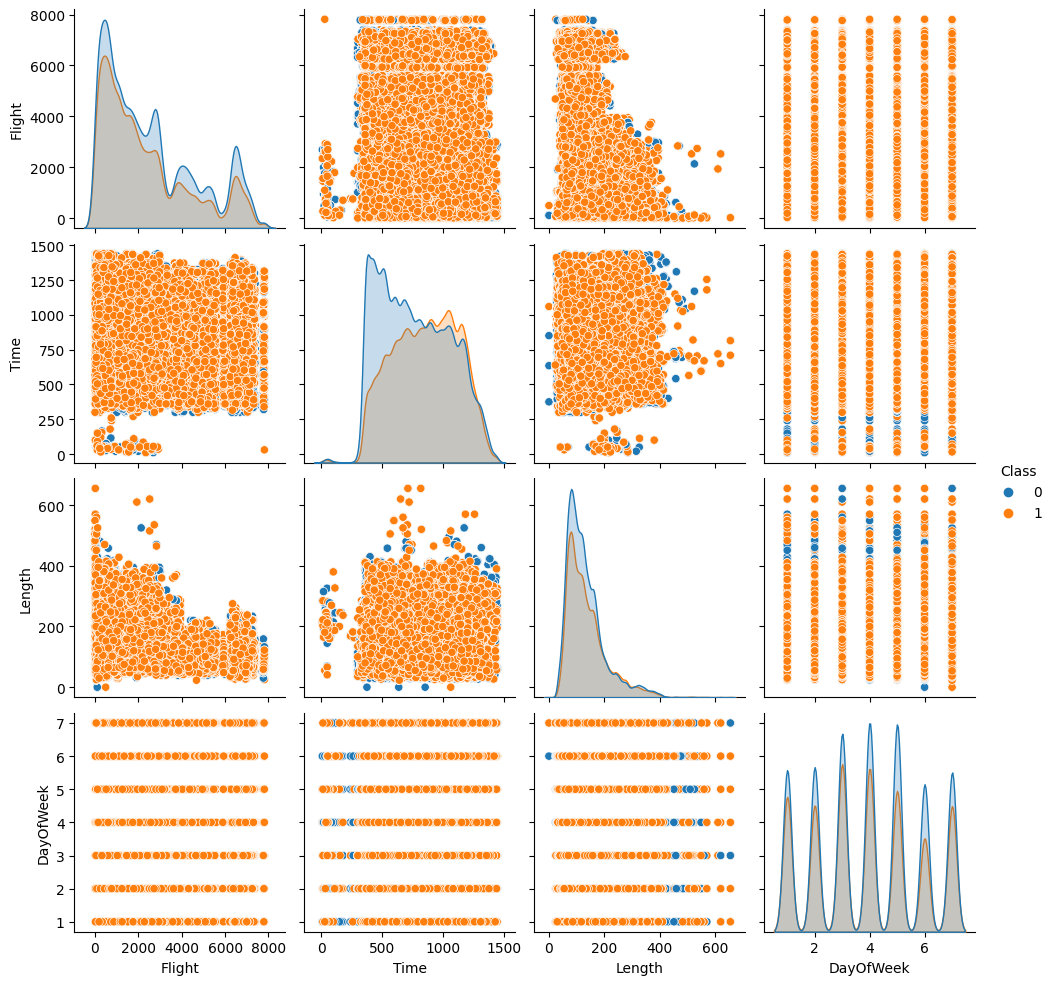

In [2]:
%matplotlib inline

sb.pairplot(data, hue='Class')

In [46]:
def detecting_outliers(data):
    outlier_percents = {}
    
    for column in data.columns:

        if data[column].dtype != object:
            
            q1 = np.quantile(data[column], 0.25)
            q3 = np.quantile(data[column], 0.75)
            iqr = q3 - q1
            upper = q3 + (1.5 * iqr)
            lower = q1 - (1.5 * iqr)
            outliers = data[(data[column] > upper) | (data[column] < lower)][column]
            outlier_percentage = len(outliers) / len(data[column]) * 100
            outlier_percents[column] = outlier_percentage
            outlier_df = pd.DataFrame(data = outlier_percents.values(), index = outlier_percents.keys(), columns = ['Outlier_%'])
            
    return outlier_df.sort_values(by = 'Outlier_%', ascending = False)
        
detecting_outliers(data)

,Outlier_%
Length,4.755442
Flight,0.000000
Time,0.000000
DayOfWeek,0.000000
Class,0.000000


#### Remove Outliers

In [ ]:
outlier_df = detecting_outliers(data)
cols_with_outliers = outlier_df[outlier_df['Outlier_%'] > 0].index
for col in cols_with_outliers:
    q1 = np.quantile(data[col], 0.25)
    q3 = np.quantile(data[col], 0.75)
    iqr = q3 - q1
    upper = q3 + (1.5 * iqr)
    lower = q1 - (1.5 * iqr)
    data = data[(data[col] <= upper) & (data[col] >= lower)]

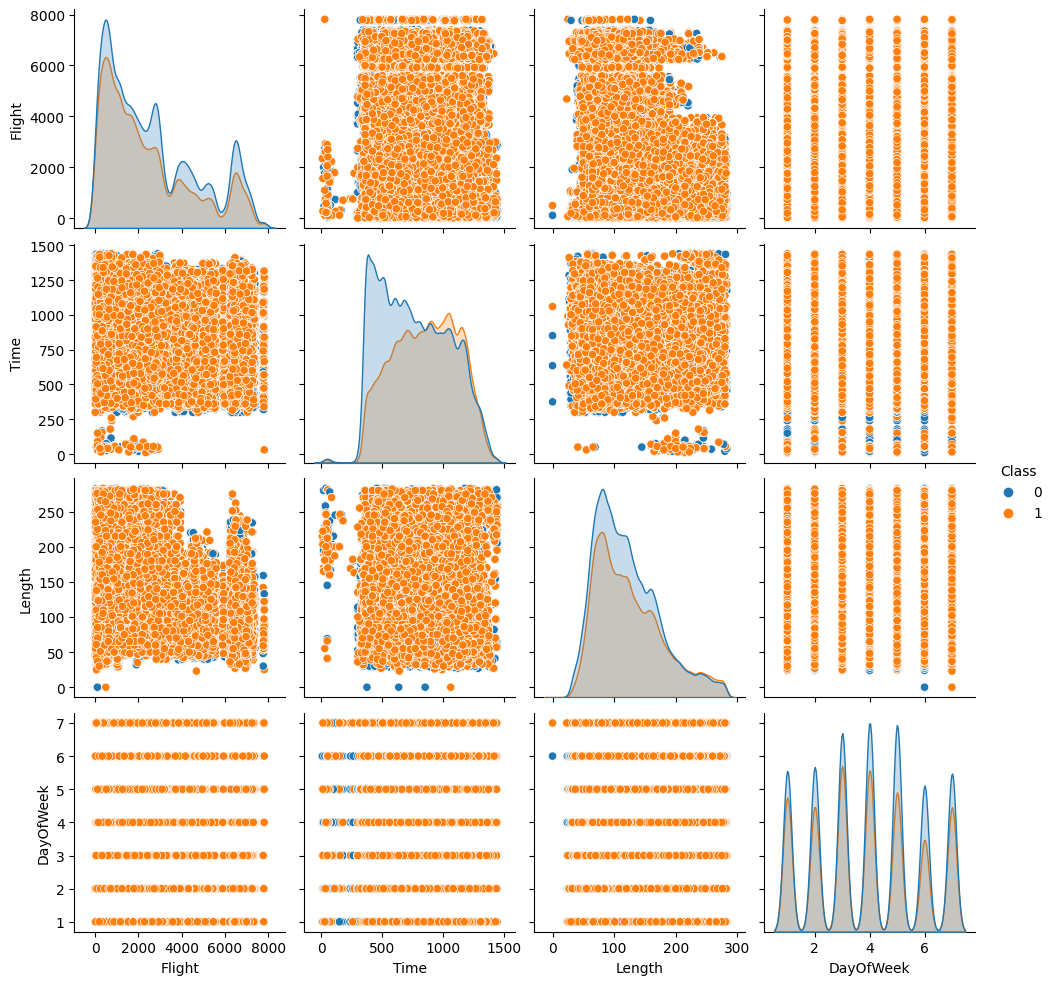

In [48]:
%matplotlib inline

sb.pairplot(data, hue='Class')  

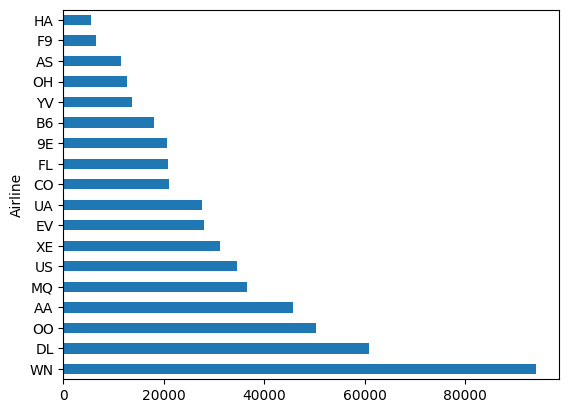

In [7]:
data['Airline'].value_counts().plot.barh()

## Algorithms

### Decision Tree